# Load Data + Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q mne
!pip install imblearn
!pip install optuna

     |████████████████████████████████| 204kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 8.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 112kB 15.7MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=061f99837615a95198c0793552881fdc74a6a7f0a9b5fe075a1c38a3a180ba1c
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.5.0-cp36-none-any.whl size=276145 sha256=34e63a8835afc13aaff32e6b919f032769bc87bf9917e230d98bd488357e57f4
  Stored in directory: /root/.cache/pip/wheels/38/21

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mne

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc

from data import DataBuildClassifier

rc('animation', html='html5')
import tensorflow
import os


# aandek 6898 samples kol wehed fih 150 points échantillonnés mil signal min 19 capteurs
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout , LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

# lstm autoencoder recreate sequence
from numpy import array
import tensorflow
from tensorflow.keras.layers import  LSTM, Dense , RepeatVector,TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from  sklearn.preprocessing import OneHotEncoder

## Define constants :

BATCH_SIZE = 6
SHUFFLE_BUFFER_SIZE = 100




# Introduction

In this challenge, we will treat electroencephalogram data and try to predict if a fixation is used for control or if it is a spontaneous one.

This can be applied to detect the user's intention to make an action by analyzing the brain signals, and automatically perfom this action, which can help him or her to focus on the main activity and rather than the motor task (mouse or keyboard manipulations).

The EEG data was recorded at $500Hz$ sampling rate for $13$ different participents using electrodes placed in $19$ positions of the brain described by polar cordinates and shown in the next figure.

In [0]:
df = pd.read_csv('drive/My Drive/eeg/order_locations.info', sep='\t', header=None, names=['channel_id', 'ang', 'dist', 'channel_name'], skiprows=1)
df.head()

,channel_id,ang,dist,channel_name
0,1,0,0.25556,Fz
1,2,-39,0.33333,F3
2,3,39,0.33333,F4
3,4,90,0.00000,Cz
4,5,-90,0.25556,C3


We used the code provided by LIKANblk at https://github.com/LIKANblk/ebci_data_loader/blob/master/data.py to load the data. Data is stored in a dictionary where keys are the participants' IDs and the values are tuples of feature vectors and labels.

In [0]:
data_loader = DataBuildClassifier('drive/My Drive/eeg/') #Path to directory with data (i.e NewData contatins 25/, 26/ ....)
all_subjects = [25,26,27,28,29,30,32,33,34,35,36,37,38]
subjects = data_loader.get_data(all_subjects, 
                                shuffle=False, 
                                windows=[(0.2,0.5)], 
                                baseline_window=(0.2,0.3), 
                                resample_to=500)
print(subjects.keys())
X, y = subjects[25]
print(X.shape) #EEG epochs (Trials) x Time x Channels
print(y.shape)

dict_keys([25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38])
(329, 150, 19)
(329,)


In [0]:
ind_0 = np.where(y == 0)[0]
ind_1 = np.where(y == 1)[0]

X_0 = X[ind_0]
X_1 = X[ind_1]

X_0_mean = np.mean(X_0, axis=0)
X_1_mean = np.mean(X_1, axis=0)

In [0]:
def polar2z(r,theta):
    return r * np.exp( 1j * (- theta + 90) * np.pi / 180 )

rs = df[['dist']].values
thetas = df[['ang']].values

xs, ys = polar2z(rs, thetas).real, polar2z(rs, thetas).imag

xycords = np.concatenate((xs, ys), axis=1)

In [0]:
fig, (ax0, ax1) = plt.subplots(1,2);

In [0]:
def animation_frame(i):
  ax0.clear()
  ax1.clear()
  im0, cn0 = mne.viz.plot_topomap(data = X_0_mean[i], pos=xycords, sphere=0.6, axes=ax0);
  im1, cn1 = mne.viz.plot_topomap(data = X_1_mean[i], pos=xycords, sphere=0.6, axes=ax1);
  return cn0, cn1

anim = FuncAnimation(fig, func=animation_frame, frames=150, interval=50);

In [0]:
html = anim.to_html5_video();

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
HTML(html)

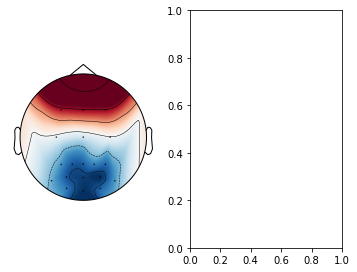

<Figure size 432x288 with 0 Axes>

In [0]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(121)
ax3 = fig2.add_subplot(122)


#fig2, (ax2, ax3) = plt.subplots(1,2)
im1, cp1 = mne.viz.plot_topomap(data = np.mean(X_0_mean, axis=0), pos=xycords, sphere=0.6, axes=ax2)
im2, cp2 = mne.viz.plot_topomap(data = np.mean(X_1_mean, axis=0), pos=xycords, sphere=0.6, axes=ax3)

In [0]:
#%matplotlib inline
%matplotlib qt
fig, axes = plt.subplots(13,2, figsize=(6, 39));

for i, key in enumerate(subjects):
  X, y = subjects[key]
  ind_0 = np.where(y == 0)[0]
  ind_1 = np.where(y == 1)[0]

  X_0 = X[ind_0]
  X_1 = X[ind_1]

  # the mean over all epoches
  X_0_mean_ep = np.mean(X_0, axis=0)
  X_1_mean_ep = np.mean(X_1, axis=0)
  
  X_0_mean_time = np.mean(X_0_mean_ep, axis=0)
  X_1_mean_time = np.mean(X_1_mean_ep, axis=0)  

  mne.viz.plot_topomap(data = X_0_mean_time, pos=xycords, sphere=0.6, axes=axes[i,0])
  mne.viz.plot_topomap(data = X_1_mean_time, pos=xycords, sphere=0.6, axes=axes[i,1])

ImportError: ignored

# Models definition 

## EEGNET

       1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    


In [0]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
   

    """       
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
 
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples,1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    0
    dense        = Dense(nb_classes, name = 'dense',
                      kernel_constraint = max_norm(norm_rate))(flatten)
    softmax = Activation('sigmoid', name = 'sigmoid')(dense)
    output=tf.reshape(softmax,(-1,1))
    
    return Model(inputs=input1, outputs=output)




## Recursive EEGNET


The EEGNet Architecture is based on **Two blocks** :

* The firt block of EEG_Net aims to generate **new channels** for our EEG instead of of the original 19.

* The second bloc tries to make sense of the temporal aspect of our data and  compress the information to a vector which is then fed to the fully connected layer.

We believe we can improve this model by dropping the second block of our model and replacing it with a **LSTM Cell**, as Recursive Neural Networks are better equiped to deal with series that convolutional ones.

In [0]:

from tensorflow import squeeze,reshape
def EEGNet2(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout',hidden_size=400):

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples,1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block1       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block1       =EEGNET BatchNormalization(axis = 1)(block1)



  ################## NEW BLOCK 2 ##############
    block2     = reshape(block1,(-1,Samples,16))
    block2       = LSTM(hidden_size) (block2)  

    ###########################################


    flatten       = block2
    
    dense        = Dense(nb_classes, name = 'dense',
                      kernel_constraint = max_norm(norm_rate))(flatten)
    sigmoid = Activation('sigmoid', name = 'sigmoid')(dense)
    output=tf.reshape(sigmoid,(-1,1))
    
    return Model(inputs=input1, outputs=output)






## Adversarial data augmentation 

Training a DNN requires large amount of data. There's no rule of thumb to determine how many data points we need. But we need more data points as our network gets deeper.

We will be training a modle for each patient. The problem is that our dataset is too small around 7000 examples, and an average of 300 samples per patient.

Even if we had enough data points, data augmentation techniques are always useful to introduce richness in our data and thus improve it's generalization capabilities.

In the previous lab we dealt with augmenting image data which was relatively easier because we as humans know the transformations (flipping / zooming ...)  that should not shift the **content ** and thus the target of an image.

For time series this question gets trickier because we cannot characterize the transformations that do not affect our **target**.

We follow [this paper](http://ssli.ee.washington.edu/~mhwang/mobvoi/2018/training-augmentation-adversarial.pdf) to generate new points using  adversarial attacks with  Fast Gradient Signed Method (FGSM).

In short, FGSM calculates the gradient in the direction that changes the model output for a certain point. One can expect that with small changes to the data point the target should not change.

Different from conventional data augmentation based on data transformations, the examples are dynamically generated based on current model parameters.






In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(model,input_image, input_label,epsilon=0.01):

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  perturbation = tf.sign(gradient)
  perturbed_image = input_image + epsilon * perturbation

  return (perturbed_image,input_label)

class CustomModel(Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        x=tf.reshape(x,(-1,19,150))
        
        
        
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass

            
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            
            loss = self.compiled_loss(y,y_pred,regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value


        ####### NOW WITH ADVERSARIAL 
        
        
        x_adv,y_adv = create_adversarial_pattern(self,x,y,epsilon=0.01)

        with tf.GradientTape() as tape:
            y_pred_adv = self(x_adv, training=True)  # Forward pass
           
       
            loss = self.compiled_loss(y_adv, y_pred_adv, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
       
        return {m.name: m.result() for m in self.metrics}



## Encoder decoder architecture

In the EEGNet blocks 1 and 2 serve **indirectly** to compress the time series data into a vector that characeterizes the times series, this vector is then fed to a fully connected layer to make the decision.

In the Encoder decoder approach we look to compress the input vector directly by having an Encoder model which compresses the input and a decoder model that tries to **reconstruct** the input from the compressed vector.

The output of the encoder is the representation of the data point in a latent space. And it can be fed to a FC layer to make predictions.

**Note :** We decided to drop this experiment for poor performance of the encoder, tuning this model required time we did not have for this lab.


In [0]:


# define model

timesteps,n_features= 150,19


model = Sequential()
model.add(LSTM(128, dropout=0.3, input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(250, dropout=0.3,return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

loss = tf.keras.losses.MSLE
model.compile(optimizer='adam', loss=loss)


X_train_dset = tensorflow.data.Dataset.from_tensor_slices((X,X)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

X_test_dset = X_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


model.fit(X_dataset .prefetch(tf.data.experimental.AUTOTUNE)
,epochs=50,verbose=2)

NameError: ignored

In [0]:
encoder=Model(model.input,outputs=model.layers[1].output)
encoder.trainable= False

encoder=Model(model.input,outputs=model.layers[1].output)
train_dataset = tensorflow.data.Dataset.from_tensor_slices((X,y)).batch(BATCH_SIZE)



input1   = Input(shape = (150,19))
encoded= encoder(input1)
target = Dense(2,activation='elu')(encoded)

predictor=Model(input1,target)
predictor.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])
predictor.fit(train_dataset,epochs=100,verbose=2)


# Model selection :

## UTIL Functions

In [0]:
from sklearn.model_selection import train_test_split

def load_data(sampling_rate):

  data_loader = DataBuildClassifier('drive/My Drive/eeg/') #Path to directory with data (i.e NewData contatins 25/, 26/ ....)
  all_subjects = [25,26,27,28,29,30,32,33,34,35,36,37,38]
  subjects = data_loader.get_data(all_subjects, 
                                  shuffle=False, 
                                  windows=[(0.2,0.5)], 
                                  baseline_window=(0.2,0.3), 
                                  resample_to=sampling_rate)
  

  for i, key in enumerate(subjects):
    if i == 0:
        X = subjects[key][0]
        y = subjects[key][1]
    else:
        X = np.concatenate((X, subjects[key][0]), axis=0)
        y = np.concatenate((y, subjects[key][1]), axis=0)

  return(subjects,X,y)

def separate_last_block(x, y, test_size=0.2):
    x_t, x_nt = x[y == 1], x[y == 0]
    x_t_tr, x_t_tst = train_test_split(x_t, test_size=test_size, shuffle=False)
    x_nt_tr, x_nt_tst = train_test_split(x_nt, test_size=test_size, shuffle=False)
    x_tr = np.concatenate((x_t_tr,x_nt_tr),axis=0)
    y_tr = np.hstack((np.ones(x_t_tr.shape[0]),np.zeros(x_nt_tr.shape[0])))
    x_tst = np.concatenate((x_t_tst,x_nt_tst),axis=0)
    y_tst = np.hstack((np.ones(x_t_tst.shape[0]), np.zeros(x_nt_tst.shape[0])))
    return x_tr,y_tr,x_tst,y_tst

subjects,X,y= load_data(500)

In [0]:
from multiprocessing import Process
import threading
from sklearn.model_selection import StratifiedKFold
import gc

def test_fit_subject(curr_subject,model,subjects):

    curr_X, curr_y = subjects[curr_subject][0], subjects[curr_subject][1]
    samples=curr_X.shape[1]
    channels=curr_X.shape[2]
    x_tr, y_tr, x_tst, y_tst = separate_last_block(curr_X.reshape(-1,channels,samples), curr_y, test_size=0.2)

   
    auc=tf.keras.metrics.AUC(name="auc")

    cmodel = tensorflow.keras.models.clone_model(model)

    cmodel.compile(loss= "binary_crossentropy", 
                  optimizer='adam', 
                  metrics = ['accuracy',auc])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_auc', 
      verbose=0,
      patience=40,
      mode='max',
      restore_best_weights=True)

    history = cmodel.fit(x_tr,y=y_tr,validation_data=(x_tst,y_tst), epochs=200, verbose=0,callbacks=[early_stopping])
    res=(history.history['val_auc'][-1])
  
    
    print("subject ",curr_subject," validation AUC is  ",res)
    return res


def fit_subject(curr_subject,model,subjects):

    curr_X, curr_y = subjects[curr_subject][0], subjects[curr_subject][1]
    samples=curr_X.shape[1]
    channels=curr_X.shape[2]
    x_tr, y_tr, x_tst, y_tst = separate_last_block(curr_X.reshape(-1,channels,samples), curr_y, test_size=0.2)
    #print("Participant", curr_subject)

    cv = StratifiedKFold(n_splits=3, shuffle=True)
    cv_splits = list(cv.split(x_tr, y_tr))
    subject_aucs=[]

    for fold, (train_idx, val_idx) in enumerate(cv_splits):
              
              
              x_tr_fold, y_tr_fold = x_tr[train_idx], y_tr[train_idx]
              x_val_fold, y_val_fold = x_tr[val_idx], y_tr[val_idx]

              train_dset =  tensorflow.data.Dataset.from_tensor_slices((x_tr_fold,y_tr_fold)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).cache()
              test_dset =   tensorflow.data.Dataset.from_tensor_slices((x_val_fold,y_val_fold)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).cache()
          
              auc=tf.keras.metrics.AUC(name="auc")

              cmodel = tensorflow.keras.models.clone_model(model)

              cmodel.compile(loss= "binary_crossentropy", 
                            optimizer='adam', 
                            metrics = ['accuracy',auc])
              
              early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_auc', 
                verbose=0,
                patience=10,
                mode='max',
                restore_best_weights=True)
          
              history = cmodel.fit(train_dset,validation_data=test_dset, epochs=50, verbose=0,callbacks=[early_stopping])
              subject_aucs.append(history.history['val_auc'][-1])
    #hist[curr_subject] = history
    subject_avg_auc= sum(subject_aucs)/len(subject_aucs)
    print("subject ",curr_subject," cross validation auc is ",subject_avg_auc)
    return (subject_avg_auc,cmodel)



def fit_model(model,X,y,subjects):
  hist = {}
  aucs=[]
  models={}
  for curr_subject in subjects.keys():
    subject_kfold_auc,model=fit_subject(curr_subject,model,subjects)
    models[curr_subject]=model
    aucs.append(subject_kfold_auc)


  return(sum(aucs)/len(aucs), aucs , models)





## Hyper parameter optimization (Optuna)

EEG data differs signifigicantly from one subject to another.As a matter of fact when training a model to make predictions for all the patients our model's performance is comparable to that of a dummy model that outputs always 1.

For this reason we will need to train a separate model for each patient. 

For the training procedure we will perform a 3 fold cross validation on each patient. Then we average the cross validation score among all patients to get our models performance.

We use Optuna library to do hyper parameter optimization, **hyper parameters are the same across all subjects.**

For the parameters we chose to work with :

Sampling rate, number of spatial filters (D) , number of temporal filters (F1) .. for the RNN version we also add the "hidden_size" parameter wich represents the **dimension of the latent space** to which the sequence is encoded.

While choosing parameters to optimize we omitted the **learning rate** parameter, for it will have an influence on the number of epochs we will need to train.

During other experiences we noticed a positive impact of small batch sizes on our model. This is probably due to the low cardinality of data per subject. Thus we train with a batch size of 6. This also can be seen as a form of regularization as **a larger batch size leads to more overfitting.**



In [178]:
from copy import deepcopy
import optuna
from keras.backend.tensorflow_backend import set_session


def objective(trial):
 

    
    params= {
       
        "nb_classes": 1,
        "Chans":int(19),
        "sampling_rate": int(trial.suggest_loguniform("sampling_rate",200,500)), #### SAMPLING RATE
        'D': int(trial.suggest_discrete_uniform("D",2,7,1)),
        'F1': int(trial.suggest_discrete_uniform("F1",10,20,2)),
        'dropoutType': trial.suggest_categorical('dropoutType', ['SpatialDropout2D','Dropout']),
        'dropoutRate':trial.suggest_uniform('dropout',0.2,0.6),
        'norm_rate':trial.suggest_uniform ('norm_rate',0.1,0.4),
        'hidden_size':int(trial.suggest_uniform('hidden_size',100,600))
        
      
    }

  
    
    subjects,X,y= load_data(params["sampling_rate"])

    
    params['Samples']= X.shape[1]
    params['kernLength'] = params['Samples']//2
    
    tmp = deepcopy(params)
    tmp.pop('sampling_rate')
    
    model = EEGNet2(**tmp)
    score,_,_ = fit_model(model,X,y,subjects)
    
    return score


if __name__ == "__main__":
    study = optuna.create_study( direction="maximize")
    
    study.optimize(objective, n_trials=10,n_jobs=1)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    best_trial = study.best_trial

    print("  Value: {}".format(best_trial.value))
    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))

subject  25  cross validation auc is  0.5500544806321462
subject  26  cross validation auc is  0.5415019591649374
subject  27  cross validation auc is  0.7027895847956339
subject  28  cross validation auc is  0.7076797286669413
subject  29  cross validation auc is  0.5881204406420389
subject  30  cross validation auc is  0.5736167828241984
subject  32  cross validation auc is  0.5161363879839579
subject  33  cross validation auc is  0.5189573963483175
subject  34  cross validation auc is  0.5332119365533193
subject  35  cross validation auc is  0.5223170518875122
subject  36  cross validation auc is  0.5503557125727335
subject  37  cross validation auc is  0.48951228459676105
subject  38  cross validation auc is  0.5468630790710449


[I 2020-06-09 18:53:05,717] Finished trial#0 with value: 0.564701294287657 with parameters: {'sampling_rate': 294.17253459930856, 'D': 7.0, 'F1': 16.0, 'dropoutType': 'SpatialDropout2D', 'dropout': 0.4065782269727146, 'norm_rate': 0.36418614066547805, 'hidden_size': 493.1013044201371}. Best is trial#0 with value: 0.564701294287657.


subject  25  cross validation auc is  0.6069325009981791
subject  26  cross validation auc is  0.5707848866780599
subject  27  cross validation auc is  0.6794568498929342
subject  28  cross validation auc is  0.5646241903305054
subject  29  cross validation auc is  0.7278042634328207
subject  30  cross validation auc is  0.5640456676483154
subject  32  cross validation auc is  0.5593181947867075
subject  33  cross validation auc is  0.6390135486920675
subject  34  cross validation auc is  0.5065835118293762
subject  35  cross validation auc is  0.5085595548152924
subject  36  cross validation auc is  0.5436311562856039
subject  37  cross validation auc is  0.5606645147005717
subject  38  cross validation auc is  0.4620757003625234


[I 2020-06-09 19:01:40,303] Finished trial#1 with value: 0.5764226569579198 with parameters: {'sampling_rate': 243.38854016410448, 'D': 4.0, 'F1': 18.0, 'dropoutType': 'SpatialDropout2D', 'dropout': 0.4213993210188731, 'norm_rate': 0.3996955009812252, 'hidden_size': 345.25523367163817}. Best is trial#1 with value: 0.5764226569579198.


subject  25  cross validation auc is  0.5439837376276652
subject  26  cross validation auc is  0.5469347635904948
subject  27  cross validation auc is  0.6971005201339722
subject  28  cross validation auc is  0.643831710020701
subject  29  cross validation auc is  0.675436774889628
subject  30  cross validation auc is  0.5135704775651296
subject  32  cross validation auc is  0.5669697125752767
subject  33  cross validation auc is  0.7316848039627075
subject  34  cross validation auc is  0.5073891480763754
subject  35  cross validation auc is  0.5601117412249247
subject  36  cross validation auc is  0.5852811535199484
subject  37  cross validation auc is  0.5730216900507609
subject  38  cross validation auc is  0.5290093421936035


[I 2020-06-09 19:12:03,657] Finished trial#2 with value: 0.5903327365716298 with parameters: {'sampling_rate': 437.4335582339642, 'D': 5.0, 'F1': 20.0, 'dropoutType': 'Dropout', 'dropout': 0.4916534167875783, 'norm_rate': 0.22322045000560142, 'hidden_size': 175.65321729068285}. Best is trial#2 with value: 0.5903327365716298.


subject  25  cross validation auc is  0.5598034262657166
subject  26  cross validation auc is  0.5634172956148783
subject  27  cross validation auc is  0.6577935814857483
subject  28  cross validation auc is  0.6684232354164124
subject  29  cross validation auc is  0.6742089788118998
subject  30  cross validation auc is  0.590272068977356
subject  32  cross validation auc is  0.541287879149119
subject  33  cross validation auc is  0.6446231802304586
subject  34  cross validation auc is  0.5436186989148458
subject  35  cross validation auc is  0.5711986819903055
subject  36  cross validation auc is  0.5238871375719706
subject  37  cross validation auc is  0.5996352235476176
subject  38  cross validation auc is  0.5050057371457418


[I 2020-06-09 19:27:31,674] Finished trial#3 with value: 0.5879365480863131 with parameters: {'sampling_rate': 327.12949304053524, 'D': 2.0, 'F1': 12.0, 'dropoutType': 'Dropout', 'dropout': 0.46750474243159484, 'norm_rate': 0.38960811357607117, 'hidden_size': 552.7616146633411}. Best is trial#2 with value: 0.5903327365716298.


subject  25  cross validation auc is  0.5111099680264791
subject  26  cross validation auc is  0.48244185249010724
subject  27  cross validation auc is  0.6639498074849447
subject  28  cross validation auc is  0.5797793865203857
subject  29  cross validation auc is  0.6650960445404053
subject  30  cross validation auc is  0.5362717906634012
subject  32  cross validation auc is  0.5228030383586884
subject  33  cross validation auc is  0.6896251837412516
subject  34  cross validation auc is  0.5835258960723877
subject  35  cross validation auc is  0.6329651872316996
subject  36  cross validation auc is  0.5700344840685526
subject  37  cross validation auc is  0.5687893231709799
subject  38  cross validation auc is  0.5530367990334829


[I 2020-06-09 19:35:29,499] Finished trial#4 with value: 0.5814945201079051 with parameters: {'sampling_rate': 219.04974343050455, 'D': 5.0, 'F1': 10.0, 'dropoutType': 'Dropout', 'dropout': 0.5478754640835779, 'norm_rate': 0.19848906598113294, 'hidden_size': 108.12585246188347}. Best is trial#2 with value: 0.5903327365716298.


subject  25  cross validation auc is  0.5208505590756735
subject  26  cross validation auc is  0.5299160579840342
subject  27  cross validation auc is  0.7041448553403219
subject  28  cross validation auc is  0.6161764860153198
subject  29  cross validation auc is  0.6009710232416788
subject  30  cross validation auc is  0.5991093715031942
subject  32  cross validation auc is  0.5476515094439188
subject  33  cross validation auc is  0.6326287587483724
subject  34  cross validation auc is  0.498713215192159
subject  35  cross validation auc is  0.5032487908999125
subject  36  cross validation auc is  0.5733733872572581
subject  37  cross validation auc is  0.5196362833182017
subject  38  cross validation auc is  0.5413806239763895


[I 2020-06-09 19:48:03,946] Finished trial#5 with value: 0.5682923786151104 with parameters: {'sampling_rate': 495.7933015572856, 'D': 6.0, 'F1': 18.0, 'dropoutType': 'Dropout', 'dropout': 0.4896171619578974, 'norm_rate': 0.17341924408440157, 'hidden_size': 311.52980805875654}. Best is trial#2 with value: 0.5903327365716298.


subject  25  cross validation auc is  0.5503379305203756
subject  26  cross validation auc is  0.5351647138595581
subject  27  cross validation auc is  0.5644921362400055
subject  28  cross validation auc is  0.5709150632222494
subject  29  cross validation auc is  0.6423476338386536
subject  30  cross validation auc is  0.5559979677200317
subject  32  cross validation auc is  0.5
subject  33  cross validation auc is  0.5518655180931091
subject  34  cross validation auc is  0.5234885613123575
subject  35  cross validation auc is  0.4907252589861552
subject  36  cross validation auc is  0.5577233533064524
subject  37  cross validation auc is  0.5191851456960043
subject  38  cross validation auc is  0.4915379484494527


[I 2020-06-09 19:59:01,054] Finished trial#6 with value: 0.5425985562495697 with parameters: {'sampling_rate': 379.217898827663, 'D': 4.0, 'F1': 18.0, 'dropoutType': 'SpatialDropout2D', 'dropout': 0.4322810911037906, 'norm_rate': 0.16631841374512124, 'hidden_size': 366.17172359861627}. Best is trial#2 with value: 0.5903327365716298.


subject  25  cross validation auc is  0.5782442887624105
subject  26  cross validation auc is  0.5931266148885092
subject  27  cross validation auc is  0.7020252545674642
subject  28  cross validation auc is  0.6542075276374817
subject  29  cross validation auc is  0.6746311187744141
subject  30  cross validation auc is  0.5986506740252177
subject  32  cross validation auc is  0.5809848308563232
subject  33  cross validation auc is  0.7118424375851949
subject  34  cross validation auc is  0.44973565141359967
subject  35  cross validation auc is  0.46617021163304645
subject  36  cross validation auc is  0.5524773498376211
subject  37  cross validation auc is  0.5040266911188761
subject  38  cross validation auc is  0.5250047842661539


[I 2020-06-09 20:09:22,193] Finished trial#7 with value: 0.5839328796435624 with parameters: {'sampling_rate': 479.5631860693477, 'D': 4.0, 'F1': 14.0, 'dropoutType': 'Dropout', 'dropout': 0.4992280628911555, 'norm_rate': 0.21351374466207076, 'hidden_size': 226.32141713586387}. Best is trial#2 with value: 0.5903327365716298.


subject  25  cross validation auc is  0.5459557970364889
subject  26  cross validation auc is  0.49703489740689594
subject  27  cross validation auc is  0.6998864412307739
subject  28  cross validation auc is  0.6588643590609232
subject  29  cross validation auc is  0.6153612732887268
subject  30  cross validation auc is  0.564194937547048
subject  32  cross validation auc is  0.5253030359745026
subject  33  cross validation auc is  0.5307222704092661
subject  34  cross validation auc is  0.5916541417439779
subject  35  cross validation auc is  0.626232365767161
subject  36  cross validation auc is  0.5273935397466024
subject  37  cross validation auc is  0.631036659081777
subject  38  cross validation auc is  0.5459572672843933


[I 2020-06-09 20:17:40,710] Finished trial#8 with value: 0.5815074604291183 with parameters: {'sampling_rate': 419.5627793401825, 'D': 4.0, 'F1': 14.0, 'dropoutType': 'Dropout', 'dropout': 0.3754816649105341, 'norm_rate': 0.34441600183691884, 'hidden_size': 129.9024431269807}. Best is trial#2 with value: 0.5903327365716298.


subject  25  cross validation auc is  0.5953840414683024
subject  26  cross validation auc is  0.5703359047571818
subject  27  cross validation auc is  0.7089638511339823
subject  28  cross validation auc is  0.6600898702939352
subject  29  cross validation auc is  0.6451886892318726
subject  30  cross validation auc is  0.5185678501923879
subject  32  cross validation auc is  0.5565909147262573
subject  33  cross validation auc is  0.5546460648377737
subject  34  cross validation auc is  0.4848319391409556
subject  35  cross validation auc is  0.5040185550848643
subject  36  cross validation auc is  0.5260688066482544
subject  37  cross validation auc is  0.5168561637401581
subject  38  cross validation auc is  0.46460241079330444


[I 2020-06-09 20:29:21,811] Finished trial#9 with value: 0.5620111586191716 with parameters: {'sampling_rate': 479.6866371967063, 'D': 5.0, 'F1': 10.0, 'dropoutType': 'SpatialDropout2D', 'dropout': 0.43766409140762186, 'norm_rate': 0.30933064155918955, 'hidden_size': 324.79804307599}. Best is trial#2 with value: 0.5903327365716298.


Number of finished trials: 10
Best trial:
  Value: 0.5903327365716298
  Params: 
    sampling_rate: 437.4335582339642
    D: 5.0
    F1: 20.0
    dropoutType: Dropout
    dropout: 0.4916534167875783
    norm_rate: 0.22322045000560142
    hidden_size: 175.65321729068285


In [0]:
from copy import deepcopy
import optuna
from keras.backend.tensorflow_backend import set_session


def objective(trial):
 

    
    params= {
       
        "nb_classes": 1,
        "Chans":int(19),
        "sampling_rate": int(trial.suggest_loguniform("sampling_rate",200,500)), #### SAMPLING RATE
        'D': int(trial.suggest_discrete_uniform("D",2,7,1)),
        'F1': int(trial.suggest_discrete_uniform("F1",10,20,2)),
        #'dropoutType': trial.suggest_categorical('dropoutType', ['SpatialDropout2D','Dropout']),
        'dropoutRate':trial.suggest_uniform('dropout',0.2,0.6),
        'norm_rate':trial.suggest_uniform ('norm_rate',0.1,0.4),
        
      
    }

  
    
    subjects,X,y= load_data(params["sampling_rate"])

    
    params['Samples']= X.shape[1]
    params['kernLength'] = params['Samples']//2
    
    tmp = deepcopy(params)
    tmp.pop('sampling_rate')
    
    model = EEGNet(**tmp)
    score,_,_ = fit_model(model,X,y,subjects)
    
    return score
  


if __name__ == "__main__":
    study = optuna.create_study( direction="maximize")
    
    study.optimize(objective, n_trials=10,n_jobs=1)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    best_trial = study.best_trial

    print("  Value: {}".format(best_trial.value))
    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))

subject  25  cross validation auc is  0.5545987685521444
subject  26  cross validation auc is  0.5110982060432434
subject  27  cross validation auc is  0.6639086802800497
subject  28  cross validation auc is  0.6544934511184692
subject  29  cross validation auc is  0.6317564845085144
subject  30  cross validation auc is  0.5374701619148254
subject  32  cross validation auc is  0.5297727187474569
subject  33  cross validation auc is  0.6056025425593058
subject  34  cross validation auc is  0.5419336557388306
subject  35  cross validation auc is  0.5690883795420328
subject  36  cross validation auc is  0.5570367177327474
subject  37  cross validation auc is  0.5478103756904602
subject  38  cross validation auc is  0.5201659003893534


[I 2020-06-09 17:56:28,821] Finished trial#0 with value: 0.5711335417551873 with parameters: {'sampling_rate': 266.9092488042957, 'D': 7.0, 'F1': 12.0, 'dropout': 0.2858150962653048, 'norm_rate': 0.23651229157306844}. Best is trial#0 with value: 0.5711335417551873.


subject  25  cross validation auc is  0.5316811899344126
subject  26  cross validation auc is  0.5052519341309866
subject  27  cross validation auc is  0.6512909928957621
subject  28  cross validation auc is  0.6073120832443237
subject  29  cross validation auc is  0.632778545220693
subject  30  cross validation auc is  0.5675706068674723
subject  32  cross validation auc is  0.5336363712946574
subject  33  cross validation auc is  0.5315235654513041
subject  34  cross validation auc is  0.5116812785466512
subject  35  cross validation auc is  0.5965690215428671
subject  36  cross validation auc is  0.5429664651552836
subject  37  cross validation auc is  0.5654333829879761
subject  38  cross validation auc is  0.5774218042691549


[I 2020-06-09 18:01:00,391] Finished trial#1 with value: 0.5657782493493495 with parameters: {'sampling_rate': 311.290642346325, 'D': 2.0, 'F1': 10.0, 'dropout': 0.4670526417263701, 'norm_rate': 0.3320097610765448}. Best is trial#0 with value: 0.5711335417551873.


subject  25  cross validation auc is  0.5987007220586141
subject  26  cross validation auc is  0.49684107303619385
subject  27  cross validation auc is  0.645676056543986
subject  28  cross validation auc is  0.6098856131235758
subject  29  cross validation auc is  0.6985040704409281
subject  30  cross validation auc is  0.5168025195598602
subject  32  cross validation auc is  0.4643939435482025
subject  33  cross validation auc is  0.5861608386039734
subject  34  cross validation auc is  0.5920529762903849
subject  35  cross validation auc is  0.5645117362340292
subject  36  cross validation auc is  0.5166243116060892
subject  37  cross validation auc is  0.6201465924580892
subject  38  cross validation auc is  0.5441218415896097


[I 2020-06-09 18:06:07,121] Finished trial#2 with value: 0.5734170996225797 with parameters: {'sampling_rate': 216.30755547085275, 'D': 7.0, 'F1': 18.0, 'dropout': 0.2136942653488575, 'norm_rate': 0.3770812607549072}. Best is trial#2 with value: 0.5734170996225797.


subject  25  cross validation auc is  0.6084346175193787
subject  26  cross validation auc is  0.5131976902484894
subject  27  cross validation auc is  0.588204046090444
subject  28  cross validation auc is  0.5292483965555826
subject  29  cross validation auc is  0.6143499215443929
subject  30  cross validation auc is  0.5290862719217936
subject  32  cross validation auc is  0.5426514943440756
subject  33  cross validation auc is  0.53932124376297
subject  34  cross validation auc is  0.4680686891078949
subject  35  cross validation auc is  0.5807907581329346
subject  36  cross validation auc is  0.5170561174551646
subject  37  cross validation auc is  0.5645971099535624
subject  38  cross validation auc is  0.5222158829371134


[I 2020-06-09 18:10:09,471] Finished trial#3 with value: 0.547478633813369 with parameters: {'sampling_rate': 261.82491937457627, 'D': 2.0, 'F1': 20.0, 'dropout': 0.5099419052601433, 'norm_rate': 0.1595245606874872}. Best is trial#2 with value: 0.5734170996225797.


subject  25  cross validation auc is  0.5349873304367065
subject  26  cross validation auc is  0.5209722419579824
subject  27  cross validation auc is  0.6361914078394572
subject  28  cross validation auc is  0.593137284119924
subject  29  cross validation auc is  0.6494287451108297
subject  30  cross validation auc is  0.4951792558034261
subject  32  cross validation auc is  0.46621212363243103
subject  33  cross validation auc is  0.5184977352619171
subject  34  cross validation auc is  0.5703481038411459
subject  35  cross validation auc is  0.5516541401545206
subject  36  cross validation auc is  0.5402766565481821
subject  37  cross validation auc is  0.6060185432434082
subject  38  cross validation auc is  0.5338482161362966


[I 2020-06-09 18:15:08,054] Finished trial#4 with value: 0.5551347526220175 with parameters: {'sampling_rate': 216.02738603795314, 'D': 3.0, 'F1': 14.0, 'dropout': 0.2932566246372618, 'norm_rate': 0.11934995736870066}. Best is trial#2 with value: 0.5734170996225797.


subject  25  cross validation auc is  0.5708852410316467
subject  26  cross validation auc is  0.48410852750142414
subject  27  cross validation auc is  0.6122991840044657
subject  28  cross validation auc is  0.6048202514648438
subject  29  cross validation auc is  0.6330939730008444
subject  30  cross validation auc is  0.5304328203201294
subject  32  cross validation auc is  0.5140909055868784
subject  33  cross validation auc is  0.5434862971305847
subject  34  cross validation auc is  0.5382346908251444
subject  35  cross validation auc is  0.57898477713267
subject  36  cross validation auc is  0.5085165003935496
subject  37  cross validation auc is  0.6091847022374471
subject  38  cross validation auc is  0.5453136960665385


[I 2020-06-09 18:19:24,763] Finished trial#5 with value: 0.5594962743612437 with parameters: {'sampling_rate': 253.07818415696346, 'D': 4.0, 'F1': 12.0, 'dropout': 0.4602131317601076, 'norm_rate': 0.350758341694983}. Best is trial#2 with value: 0.5734170996225797.


subject  25  cross validation auc is  0.5865375200907389
subject  26  cross validation auc is  0.4223158856232961
subject  27  cross validation auc is  0.5906086961428324
subject  28  cross validation auc is  0.5954248309135437
subject  29  cross validation auc is  0.6389772891998291
subject  30  cross validation auc is  0.48557015260060626
subject  32  cross validation auc is  0.48924243450164795
subject  33  cross validation auc is  0.5078058540821075
subject  34  cross validation auc is  0.49192286531130475
subject  35  cross validation auc is  0.5671513477961222
subject  36  cross validation auc is  0.48257972796758014
subject  37  cross validation auc is  0.5946777860323588
subject  38  cross validation auc is  0.5354929467042288


[I 2020-06-09 18:23:09,833] Finished trial#6 with value: 0.5375621028435537 with parameters: {'sampling_rate': 448.63590539898877, 'D': 7.0, 'F1': 18.0, 'dropout': 0.25518918565206605, 'norm_rate': 0.2340519013707042}. Best is trial#2 with value: 0.5734170996225797.


subject  25  cross validation auc is  0.5771518150965372
subject  26  cross validation auc is  0.4884173075358073
subject  27  cross validation auc is  0.5680169463157654
subject  28  cross validation auc is  0.530024508635203
subject  29  cross validation auc is  0.6272076368331909
subject  30  cross validation auc is  0.5562892953554789
subject  32  cross validation auc is  0.5162121256192526
subject  33  cross validation auc is  0.5295678675174713
subject  34  cross validation auc is  0.4490525722503662
subject  35  cross validation auc is  0.5531790455182394
subject  36  cross validation auc is  0.4889960289001465
subject  37  cross validation auc is  0.564225971698761
subject  38  cross validation auc is  0.5055539508660635


[I 2020-06-09 18:26:55,986] Finished trial#7 with value: 0.5349150055494063 with parameters: {'sampling_rate': 468.0643104852022, 'D': 6.0, 'F1': 10.0, 'dropout': 0.42695247497559496, 'norm_rate': 0.106784697898484}. Best is trial#2 with value: 0.5734170996225797.


subject  25  cross validation auc is  0.5001275936762491
subject  26  cross validation auc is  0.5082041223843893
subject  27  cross validation auc is  0.56938769419988
subject  28  cross validation auc is  0.5464460849761963
subject  29  cross validation auc is  0.6590613524119059
subject  30  cross validation auc is  0.5156872073809305
subject  32  cross validation auc is  0.5578787724177042
subject  33  cross validation auc is  0.5554478764533997
subject  34  cross validation auc is  0.5725367466608683
subject  35  cross validation auc is  0.5573962529500326
subject  36  cross validation auc is  0.5285290479660034
subject  37  cross validation auc is  0.6099909345308939
subject  38  cross validation auc is  0.5305825769901276


[I 2020-06-09 18:31:44,131] Finished trial#8 with value: 0.5547135586921985 with parameters: {'sampling_rate': 498.9521274584874, 'D': 5.0, 'F1': 12.0, 'dropout': 0.20490805639886017, 'norm_rate': 0.31728046150434447}. Best is trial#2 with value: 0.5734170996225797.


subject  25  cross validation auc is  0.56333660085996
subject  26  cross validation auc is  0.48946382602055866
subject  27  cross validation auc is  0.5760769844055176
subject  28  cross validation auc is  0.6171160141626993
subject  29  cross validation auc is  0.6083543499310812
subject  30  cross validation auc is  0.5778411030769348
subject  32  cross validation auc is  0.5234090785185496
subject  33  cross validation auc is  0.5093669394652048
subject  34  cross validation auc is  0.5294975439707438
subject  35  cross validation auc is  0.5387482444445292
subject  36  cross validation auc is  0.5308080712954203
subject  37  cross validation auc is  0.5912283062934875
subject  38  cross validation auc is  0.5179729262987772


[I 2020-06-09 18:35:49,085] Finished trial#9 with value: 0.5517861529802666 with parameters: {'sampling_rate': 243.17593710641626, 'D': 5.0, 'F1': 18.0, 'dropout': 0.20659262712148202, 'norm_rate': 0.14232588487420322}. Best is trial#2 with value: 0.5734170996225797.


Number of finished trials: 10
Best trial:
  Value: 0.5734170996225797
  Params: 
    sampling_rate: 216.30755547085275
    D: 7.0
    F1: 18.0
    dropout: 0.2136942653488575
    norm_rate: 0.3770812607549072


## Validation accuracy

In [195]:
params={"nb_classes": 1,"Chans":19,'Samples': 132, 'D': 5, 'F1': 20, 'dropoutType': 'Dropout', 'dropoutRate': 0.4916534167875783, 'norm_rate': 0.22322045000560142, 'hidden_size': 175,'kernLength':62}
subjects,X,y = load_data(437)

model=EEGNet2(**params)
val_aucs=[]
for subject in subjects.keys():
  sub_auc=test_fit_subject(subject,model,subjects)
  val_aucs.append(sub_auc)

print( "Validation average AUC score is ", sum(val_aucs)/len(val_aucs))


subject  25  validation AUC is   0.5109648704528809
subject  26  validation AUC is   0.6578947305679321
subject  27  validation AUC is   0.7129629850387573
subject  28  validation AUC is   0.7807692289352417
subject  29  validation AUC is   0.6477864384651184
subject  30  validation AUC is   0.5190918445587158
subject  32  validation AUC is   0.48795175552368164
subject  33  validation AUC is   0.5830159187316895
subject  34  validation AUC is   0.685835063457489
subject  35  validation AUC is   0.7109028697013855
subject  36  validation AUC is   0.5075335502624512
subject  37  validation AUC is   0.5814938545227051
subject  38  validation AUC is   0.5853383541107178
Validation average AUC score is  0.6131954972560589


# Failed experiments:

Unfortunately some of the techniques we saught to improve our model where unfructful.

We tried to parallelize model training as we will be training a model for each subject. For this end we saught to train each model on an independant thread using the **threading** module . Also we tried to used the parallelization of running experiments with Optuna with the parameter **n_jobs**.

This did not work due to problems handling Keras sessions, which caused parameter confusions when running on multiple threads. Tensorflow 2.0 being recent we could not find any workaround to his on forums.

Also we saught to generate **balanced batches** to train our model as our data is slightly skewed using [IMB Learn Balanced data generator](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.tensorflow.balanced_batch_generator.html) but we faced issues feeding the data to our model.



In [0]:
#     def __init__(self,subject,dict):
        
#         threading.Thread.__init__(self)
#         self.dict=dict
#         self.subject=subject

#     def run(self):
      
#       auc=fit_subject(self.subject)
#       #self.dict[self.subject]=auc
      

# dk={}
# ps=[]
# i=0
# for subject in subjects.keys():
#   print(subject)
#   p=Worker(subject,dk)
#   p.start()
#   ps.append(p)
 
  
# for p in ps:
#   p.join()
